In [1]:
# There is an issue with importing cli within jupyter notebooks, probably
# related to using multiprocessing. 
# import stompy.model.openfoam.cli

from stompy.spatial import field
import matplotlib.pyplot as plt
import numpy as np
from stompy import utils

In [2]:
%matplotlib widget

In [4]:
# Invoke via command line:
!python -m stompy.model.openfoam.cli --help

usage: cli.py [-h] [-c CASE] [-U] [-s] [-t TIME] [-r RES] [-f]

Postprocess OpenFOAM results, esp. depth-averaging

options:
  -h, --help            show this help message and exit
  -c CASE, --case CASE  Path to case, default is working directory
  -U, --velocity        Enable depth-averaged velocity output
  -s, --stage           Enable stage (water surface elevation) output
  -t TIME, --time TIME  Select output times as comma-separated time names, or
                        'all'
  -r RES, --res RES     Output raster cell size (positive), or count in x
                        (negative)
  -f, --force           Force overwrite existing files


In [41]:
# THIS CAN BE SLOW! First call for a new case is very slow. Subsequent calls 
# take maybe 5s per timestep
!python -m stompy.model.openfoam.cli -c ../../../raid01/data18/DWR/fishpassage-DWR-7/fishpassage-DWR-7-7cms-local -U -s -t 180 -r 0.1 -f 

Reading openfoam mesh
1 time step(s) to process
Reading mesh for processor 0
Reading mesh for processor 1
Reading mesh for processor 2
Reading mesh for processor 3
Reading mesh for processor 4
Reading mesh for processor 5
Reading mesh for processor 6
Reading mesh for processor 7
Output rasters will be 39x196
Writing output to ../../../raid01/data18/DWR/fishpassage-DWR-7/fishpassage-DWR-7-7cms-local/postProcessing/python
Reading output for processor 0
Reading file ../../../raid01/data18/DWR/fishpassage-DWR-7/fishpassage-DWR-7-7cms-local/processor0/180/U
Reading file ../../../raid01/data18/DWR/fishpassage-DWR-7/fishpassage-DWR-7-7cms-local/processor0/180/alpha.water
Reading output for processor 1
Reading file ../../../raid01/data18/DWR/fishpassage-DWR-7/fishpassage-DWR-7-7cms-local/processor1/180/U
Reading file ../../../raid01/data18/DWR/fishpassage-DWR-7/fishpassage-DWR-7-7cms-local/processor1/180/alpha.water
Reading output for processor 2
Reading file ../../../raid01/data18/DWR/fishpas

In [43]:
ls ../../../raid01/data18/DWR/fishpassage-DWR-7/fishpassage-DWR-7-7cms-local/postProcessing/python/*_180.tif

../../../raid01/data18/DWR/fishpassage-DWR-7/fishpassage-DWR-7-7cms-local/postProcessing/python/stage_180.tif*
../../../raid01/data18/DWR/fishpassage-DWR-7/fishpassage-DWR-7-7cms-local/postProcessing/python/U_180.tif*


In [44]:
# These load timename 180, a bit more interesting than 12 from the previous command
fld_wse=field.GdalGrid("../../../raid01/data18/DWR/fishpassage-DWR-7/fishpassage-DWR-7-7cms-local/postProcessing/python/stage_180.tif")
fld_U  =field.GdalGrid("../../../raid01/data18/DWR/fishpassage-DWR-7/fishpassage-DWR-7-7cms-local/postProcessing/python/U_180.tif")

Putting multiple channels as last index


In [45]:
print( "WSE output:")
print(f"  extents: {fld_wse.extents}  data shape {fld_wse.F.shape}")
print( "U output:")
print(f"  extents: {fld_U.extents}  data shape {fld_U.F.shape}")
# FIX: extents should be exact match

WSE output:
  extents: [-9.8, 9.8, -1.8287999629974372, 2.0999999999999996]  data shape (40, 196)
U output:
  extents: [-9.8, 9.8, -1.8287999629974372, 2.0999999999999996]  data shape (40, 196, 3)


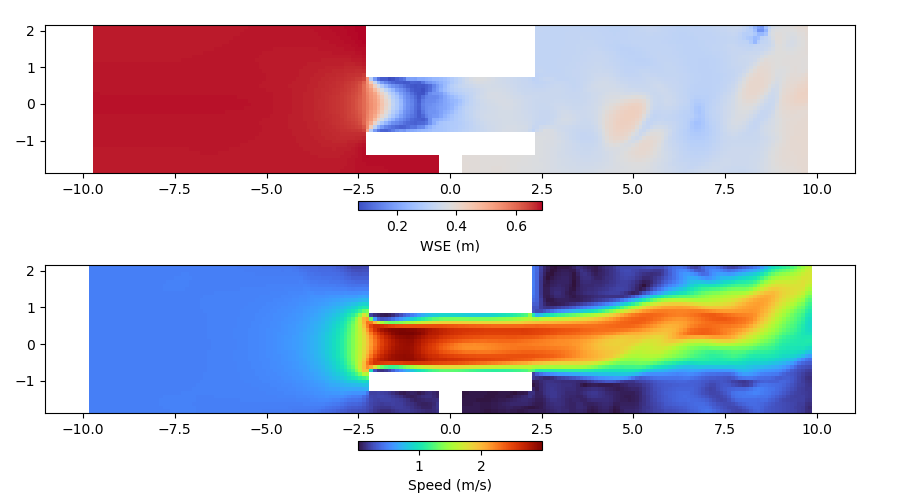

In [46]:
fig,axs=plt.subplots(2,1,figsize=(9,5))
fig.subplots_adjust(left=0.05,right=0.95,top=0.95,bottom=0.1,hspace=0.3)
for ax in axs:
    ax.set_adjustable('datalim')
fld_speed = field.SimpleGrid(extents=fld_U.extents, F=utils.mag(fld_U.F))
img_wse  = fld_wse.plot(ax=axs[0],cmap='coolwarm')
plt.colorbar(img_wse,label="WSE (m)",orientation='horizontal',ax=axs[0],fraction=0.05)
img_speed= fld_speed.plot(ax=axs[1],cmap='turbo')
plt.colorbar(img_speed,label="Speed (m/s)",orientation='horizontal',ax=axs[1],fraction=0.05) ;


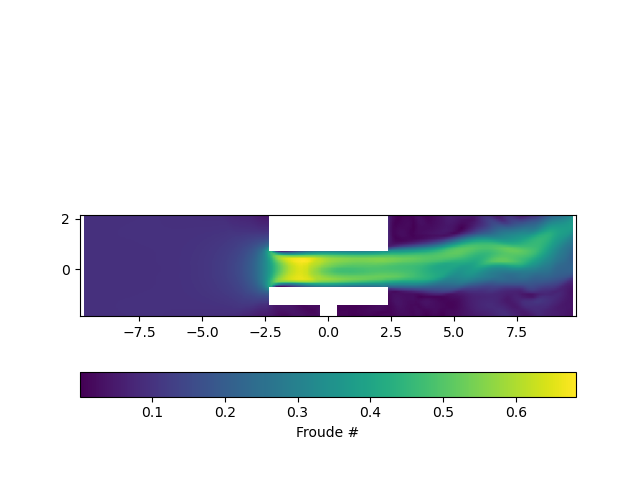

In [48]:
z_bed = -1.8288 # -6 ft, corroborated by paraview

fld_Fr = field.SimpleGrid(extents = fld_wse.extents, F=fld_speed.F/np.sqrt(9.82*(fld_wse.F+1.8288)))
fig,ax=plt.subplots()
art = fld_Fr.plot(ax=ax)
plt.colorbar(art,label="Froude #",orientation='horizontal')